In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%cd -q ..

/home/prat/miniconda3/envs/rp/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [45]:
import lcpfn.lcpfn as lcpfn
import numpy as np
from matplotlib import pyplot as plt
import lcdb
import torch
from scipy.interpolate import interp1d
import pandas as pd
import os
os.path.abspath("")
df = pd.read_pickle( 'LCDB_localised/train_curves.pkl')
import pandas as pd

FileNotFoundError: [Errno 2] No such file or directory: 'LCDB_localised/train_curves.pkl'


## Generate samples from LCDB prior

In [29]:
def get_validation_curve(rng:np.random, verbose=False):
    """Retrieve the validation curve for a given model and dataset."""
    #slect a random row from the dataframe
    row = rng.choice(df.index)
    if verbose:
        print(f"openmlid: {df.loc[row, 'openmlid']}, learner: {df.loc[row, 'learner']}")
    anchors = df.loc[row, 'anchors']
    means = df.loc[row, 'means']
    std = df.loc[row, 'std']
    return anchors, means, std

# Create a function that generates a batch of samples from the LCBD dataset


def sample_from_lcbd(n:np.random, plot=False, seq_len=100):
    return sample(n, components=None, distribution=None, plot=plot)


def sample(rng:np.random,
            components,
            distribution,
            var_lnloc=-4,
            var_lnscale=1,
            range_constraint=True,
            seq_len=100,
            plot=False):

    anchors, means, std = get_validation_curve(rng=rng)

    means = np.array(means)
    #change the anchors to be between 0 and 1
    anchors = np.array(anchors)
    anchors = (anchors - np.min(anchors)) / (np.max(anchors) - np.min(anchors))
    try:
        f = interp1d(anchors, means, kind='cubic')
    except Exception as e:
        get_validation_curve(rng, verbose=True)
        print(e)
        f = interp1d(anchors, means)

    x_smooth = np.linspace(min(anchors), max(anchors), seq_len)
    y_smooth = f(x_smooth)

    y_noise = rng.normal(0, std, seq_len)
    y_noise = y_smooth + y_noise
    y_noise = np.clip(y_noise, 0, 1)

    if plot:
        plt.scatter(anchors*100, means, label='Original Points')
        plt.plot(y_smooth, "*" ,label='Interpolated Curve', color='red', alpha=0.1)
        plt.plot(y_noise,  "*", label='Interpolated noise Curve', color='blue', alpha=0.1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.ylim(0, 1)
        plt.show()

        print("anchors", anchors.shape)
        print("means", means.shape)
        print("y_noise", y_noise.shape)
        print("y_smooth", y_smooth.shape)
        print("types:", type(y_smooth))
        print("types:", type(y_noise))


    def curve():
        return y_smooth, y_noise
    return curve


y = sample_from_lcbd(np.random, plot=True)


[autoreload of LCDB_localised.LCDB_localised failed: Traceback (most recent call last):
  File "/home/prat/miniconda3/envs/rp/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/prat/miniconda3/envs/rp/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/prat/miniconda3/envs/rp/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/LCDB_localised.py", line 7, in <module>
    pd.to_pickle(a, 'all_curves.pkl')
  File "/home/prat/miniconda3/envs/rp/lib/python3.9/site-packages/pandas/io/pickle.py", line 105, in to_pickle


NameError: name 'df' is not defined

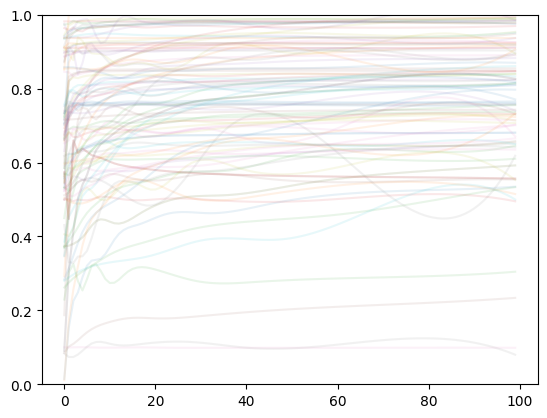

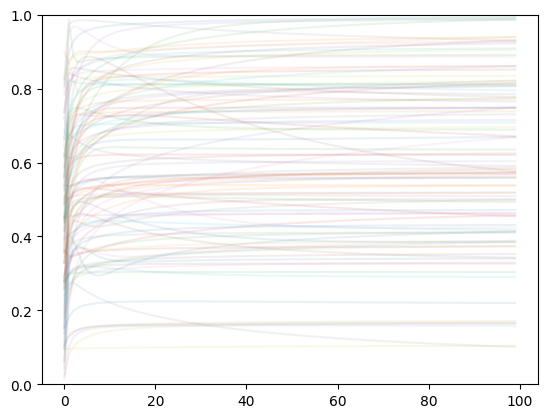

In [23]:
for _ in range(100):
    prior = sample_from_lcbd(np.random)
    curve, a = prior()
    plt.plot(curve, alpha=0.1)
plt.ylim(0, 1)
plt.show()

for _ in range(100):
    prior = lcpfn.sample_from_prior(np.random)
    curve, a = prior()
    plt.plot(curve, alpha=0.1)
plt.ylim(0, 1)
plt.show()

## Train a PFN model with the previous learning curve prior

In [24]:
# get_batch_func = lcpfn.create_get_batch_func(prior=lcpfn.sample_from_prior)
get_batch_func = lcpfn.create_get_batch_func(prior=sample_from_lcbd)
# lcpfn.sample_from_prior or sample_from_lcbd

In [25]:
# example of a batch
X, Y, y_noise = get_batch_func(batch_size=100, seq_len=100, num_features=1)
print(X.shape, Y.shape, y_noise.shape)


get_batch_domhan
y_target (100, 100)
y_noisy (100, 100)

torch.Size([100, 100, 1]) torch.Size([100, 100]) torch.Size([100, 100])


In [26]:
# Main function to train a PFN model
lcpfn.train_lcpfn

<function lcpfn.lcpfn.train_lcpfn.train_lcpfn(get_batch_func, seq_len: int = 100, emsize: int = 512, nlayers: int = 12, num_borders: int = 1000, lr: float = 0.001, batch_size: int = 100, epochs: int = 1000)>

In [ ]:
# train a small model for 3 epochs
result = lcpfn.train_lcpfn(get_batch_func=get_batch_func, 
                          seq_len=100,
                         emsize=256,
                         nlayers=3,
                         num_borders=1000,
                         lr=0.001,
                         batch_size=10,
                         epochs=3)

KeyboardInterrupt: 

In [ ]:
# Get the trained model

model = result[2]
print(model)

In [ ]:
anchors, values_train, values_valid, values_test = LCDB_localised.get_curve_from_dataframe(LCDB_localised.get_curve_as_dataframe(21, "sklearn.neural_network.MLPClassifier"))

means = [np.mean(sublist) for sublist in values_valid]

plt.plot(anchors, means, "*" ,label='Original Points')